In [0]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [0]:


    # Save data to this file
    file_to_save = '/editedABL.csv'
    print('File already exists. Loading data from CSV')
    df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


In [0]:
df.head()

,Ldcp,Open,High,Low,Current,Change,Volume,Date
0,97.95,97.11,98.0,95.2,96.78,-1.17,720,2020-01-26 00:53:20
1,97.95,97.11,98.0,95.2,96.78,-1.17,720,2020-01-26 00:53:20
2,97.95,97.11,98.0,95.2,96.78,-1.17,720,2020-01-26 00:53:20
3,97.95,97.11,98.0,95.2,96.78,-1.17,720,2020-01-26 00:53:20
4,97.95,97.11,98.0,95.2,96.78,-1.17,720,2020-01-26 00:53:20


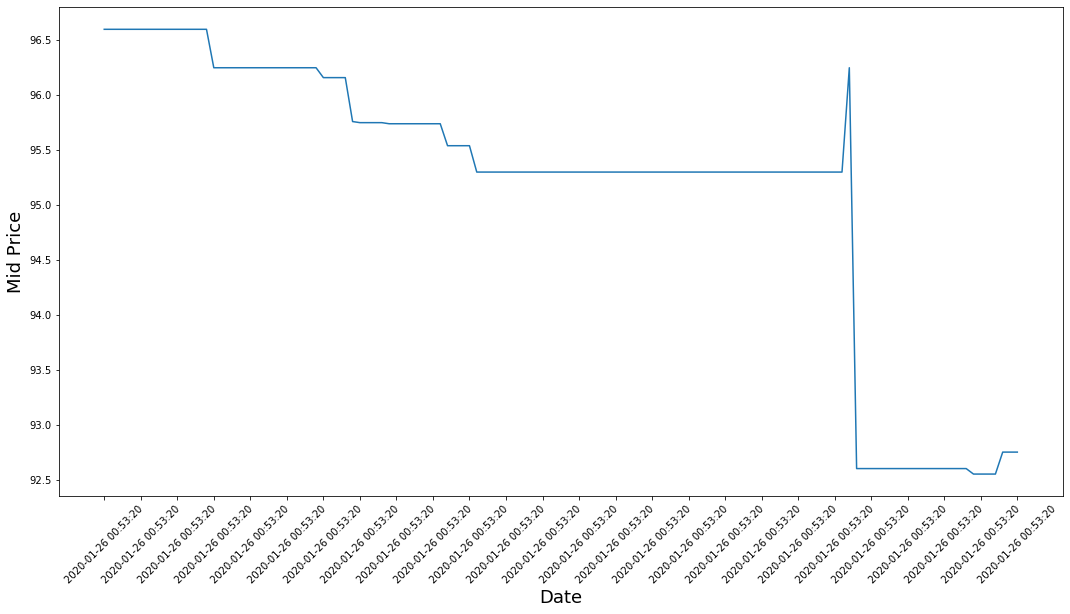

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],5),df['Date'].loc[::5],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [0]:
high_prices = df.loc[:,'high'].as_matrix()
low_prices = df.loc[:,'low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
train_data = mid_prices[:100]
test_data = mid_prices[100:]


In [0]:
print(test_data.size)

38


In [0]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [0]:
print(train_data.shape)

(100, 1)


In [0]:
smoothing_window_size = 30
for di in range(0,60,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data 
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [0]:
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [0]:
print(train_data.shape)
print(test_data.shape)

(100,)
(38,)


In [0]:
EMA = 0.0
gamma = 0.1
for ti in range(100):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [0]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']
        
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


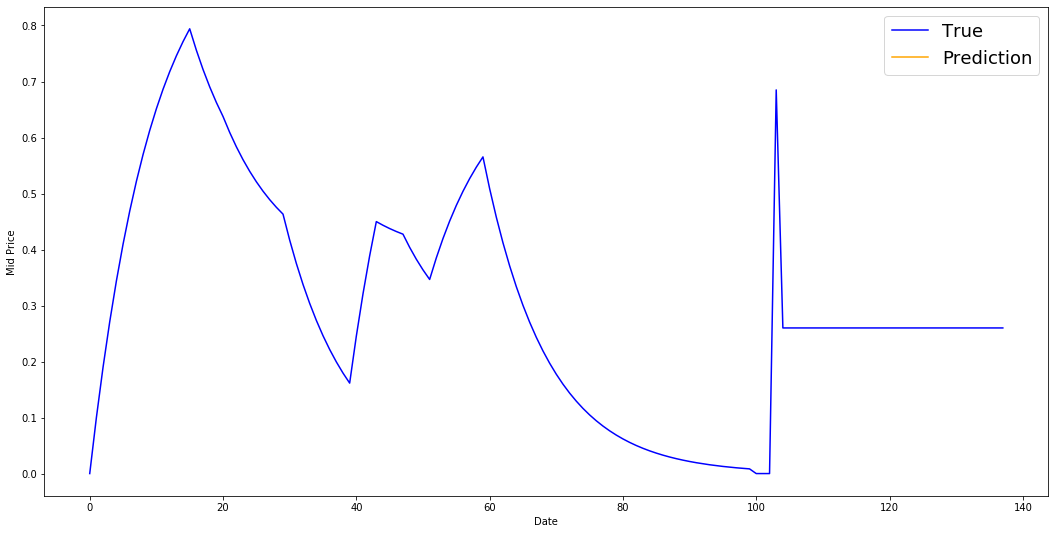

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [0]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

  if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
  else:
    date = df.loc[pred_idx,'Date']
    
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00182


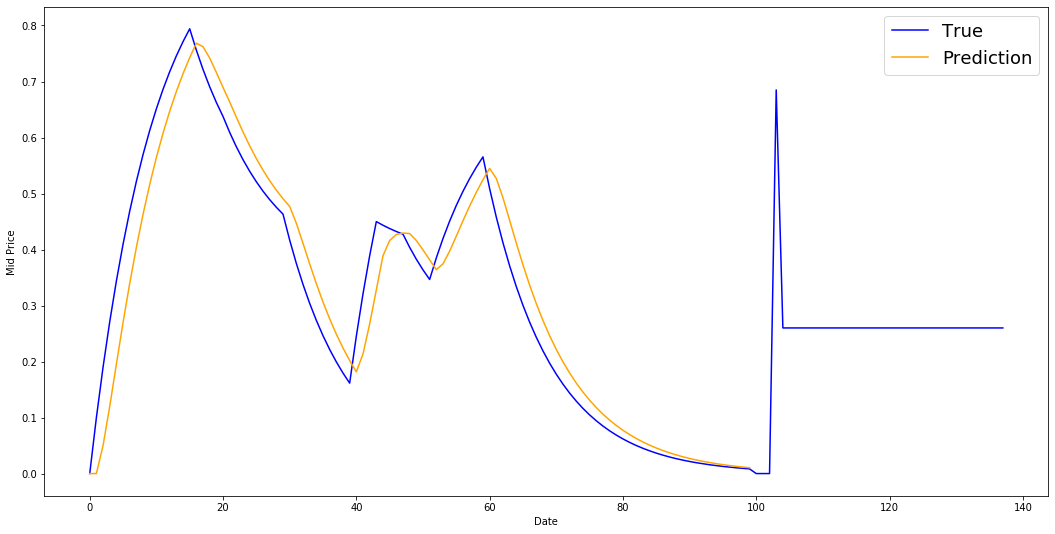

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [0]:
# class DataGeneratorSeq(object):
    
#     def __init__(self,prices,batch_size,num_unroll):
#         self._prices = prices
#         self._prices_length = len(self._prices) - num_unroll
#         self._batch_size = batch_size
#         self._num_unroll = num_unroll
#         self._segments = self._prices_length //self._batch_size
#         self._cursor = [offset * self._segments for offset in range(self._batch_size)]

#     def next_batch(self):
        
#         batch_data = np.zeros((self._batch_size),dtype=np.float32)
#         print("initial batch datat = ",batch_data)
#         print(self._batch_size)
#         batch_labels = np.zeros((self._batch_size),dtype=np.float32)
#         print("initial batch label = ",batch_labels)
#         for b in range(self._batch_size):
#             print("prices are ",self._prices_length)
#             print("above self cursor[b] is ", self._cursor[b])
#             if self._cursor[b]+1>=self._prices_length:
#                 self._cursor[b] = b * 1
#                 # self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
#             print("self cursor b+1 is ",self._cursor[b]+1) 
#             print("segement is ",self._segments)
#             # print("price list are ",self._prices)   
#             batch_data[b] = self._prices[self._cursor[b]]
#             print("value of b is ",b)
#             print("value of batchdata[b] is ",batch_data[b])
#             batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
#             print("value of batchlabel[b] is ",batch_labels[b])
#             self._cursor[b] = (self._cursor[b]+1)%self._prices_length
#             print("value of self cursor[b] is ",self._cursor[b])
#         return batch_data,batch_labels
    
#     def unroll_batches(self):
            
#         unroll_data,unroll_labels = [],[]
#         init_data, init_label = None,None
#         for ui in range(self._num_unroll):
            
#             data, labels = self.next_batch()
#             print("data is ",data)
#             print("label is ",labels)    

#             unroll_data.append(data)
#             unroll_labels.append(labels)

#         return unroll_data, unroll_labels
    
#     # def reset_indices(self):
#     #     for b in range(self._batch_size):
#     #         self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
#     #     print("indices self cursor[b] is ",self._cursor[b])
        


# dg = DataGeneratorSeq(train_data,5,5)
# u_data, u_labels = dg.unroll_batches()

# for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
#     print('\n\nUnrolled index %d'%ui)
#     dat_ind = dat
#     lbl_ind = lbl
#     print('\tInputs: ',dat )
#     print('\n\tOutput:',lbl)

initial batch datat =  [0. 0. 0. 0. 0.]
5
initial batch label =  [0. 0. 0. 0. 0.]
prices are  95
above self cursor[b] is  0
self cursor b+1 is  1
segement is  19
value of b is  0
value of batchdata[b] is  0.0
value of batchlabel[b] is  0.1
value of self cursor[b] is  1
prices are  95
above self cursor[b] is  19
self cursor b+1 is  20
segement is  19
value of b is  1
value of batchdata[b] is  0.6626207
value of batchlabel[b] is  0.58346224
value of self cursor[b] is  20
prices are  95
above self cursor[b] is  38
self cursor b+1 is  39
segement is  19
value of b is  2
value of batchdata[b] is  0.17945267
value of batchlabel[b] is  0.3887389
value of self cursor[b] is  39
prices are  95
above self cursor[b] is  57
self cursor b+1 is  58
segement is  19
value of b is  3
value of batchdata[b] is  0.5265893
value of batchlabel[b] is  0.4579606
value of self cursor[b] is  58
prices are  95
above self cursor[b] is  76
self cursor b+1 is  77
segement is  19
value of b is  4
value of batchdata[b

In [0]:
class DataGeneratorSeq(object):
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll_batches(self):
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.         0.6626207  0.17945267 0.5265893  0.09429003]

	Output: [0.3439     0.6375351  0.320821   0.56538343 0.06186369]


Unrolled index 1
	Inputs:  [0.1        0.6375351  0.1615074  0.54700726 0.08486103]

	Output: [0.271      0.53966326 0.3887389  0.41216454 0.06873743]


Unrolled index 2
	Inputs:  [0.19       0.6090757  0.24535666 0.56538343 0.07637492]

	Output: [0.3439     0.520991   0.44334003 0.37094808 0.06873743]


Unrolled index 3
	Inputs:  [0.271      0.58346224 0.320821   0.5088451  0.06873743]

	Output: [0.468559   0.520991   0.3887389  0.33385327 0.05567732]


Unrolled index 4
	Inputs:  [0.3439     0.56041014 0.3887389  0.4579606  0.06186369]

	Output: [0.468559   0.53966326 0.43746758 0.41216454 0.04058876]


In [0]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [0]:
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [0]:
print(train_outputs)

[<tf.Tensor 'train_outputs_0:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_1:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_2:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_3:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_4:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_5:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_6:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_7:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_8:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_9:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_10:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_11:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_12:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_13:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_14:0' shape=(500, 1) dtype=float32>, <tf.Tensor 'train_outputs_15:0' shape=(500, 1) dtype=float32>, <

In [0]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [0]:
print(b)

<tf.Variable 'b:0' shape=(1,) dtype=float32_ref>


In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of 
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
	All done


In [0]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [0]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(36).tolist() 

for ep in range(epochs):       
    
    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
        
    
    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:
      try:
        average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      except ZeroDivisionError:
        average_loss=0
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []
      
      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        feed_dict = {}  
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_mid_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 0.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 0.09669
	Finished Predictions
Average loss at step 2: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 3: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 4: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 5: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 6: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 7: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 8: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 9: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 10: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 11: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 12: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 13: 0.000000
	Test MSE: 0.09669
	Finished Predictions
Average loss at step 14: 0.000000
	Test MSE: 0.09669
	Finished Pred

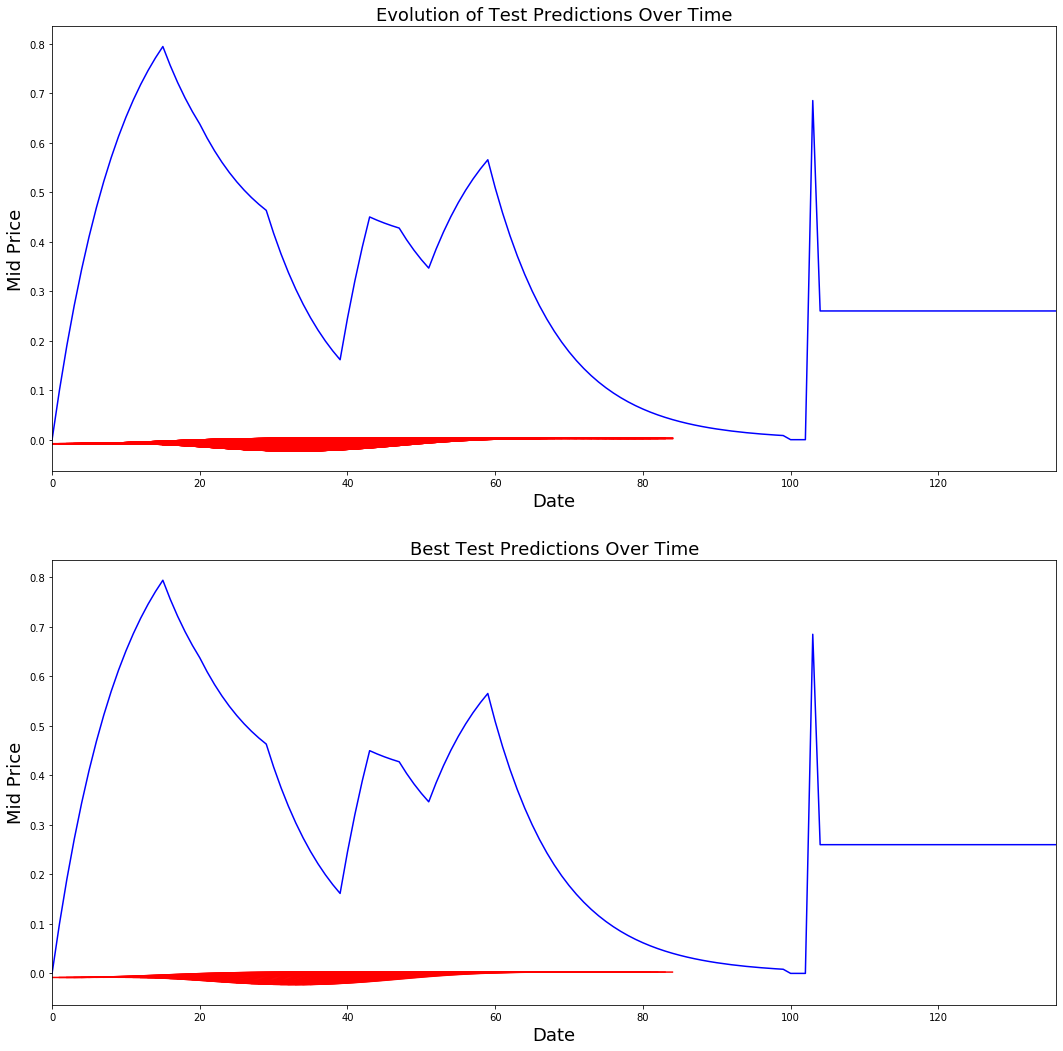

In [0]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(0,136)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
    
plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(0,136)
plt.show()